In [ ]:
!git clone https://github.com/zhmzm/FLTrust_pytorch.git
%cd FLTrust_pytorch
!git rev-parse --abbrev-ref HEAD || true


Cloning into 'FLTrust_pytorch'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 66 (delta 33), reused 17 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (66/66), 11.10 MiB | 8.52 MiB/s, done.
Resolving deltas: 100% (33/33), done.
/content/FLTrust_pytorch/FLTrust_pytorch
main


In [ ]:
import os, sys, torch

if os.path.exists("requirements.txt"):
    !pip install -r requirements.txt
else:
    !pip install torch torchvision tqdm numpy

print("Python", sys.version)
print("Torch", torch.__version__)


Python 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Torch 2.9.0+cu126


In [ ]:
import os
os.makedirs('data/MNIST', exist_ok=True)


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving t10k-images-idx3-ubyte.gz to t10k-images-idx3-ubyte.gz
Saving t10k-labels-idx1-ubyte.gz to t10k-labels-idx1-ubyte.gz
Saving train-images-idx3-ubyte.gz to train-images-idx3-ubyte.gz
Saving train-labels-idx1-ubyte.gz to train-labels-idx1-ubyte.gz


In [ ]:
import shutil
for filename in uploaded.keys():
    shutil.move(filename, 'data/MNIST/' + filename)


In [ ]:
import os
os.getcwd()


'/content/FLTrust_pytorch/FLTrust_pytorch'

In [ ]:
import os
os.makedirs('/content/FLTrust_pytorch/data/MNIST', exist_ok=True)


In [ ]:
!mkdir -p /content/data/MNIST
!cp /content/FLTrust_pytorch/data/MNIST/* /content/data/MNIST/


In [ ]:
!python src/server.py


Extracting ../data/MNIST/train-images-idx3-ubyte.gz
Extracting ../data/MNIST/train-labels-idx1-ubyte.gz
Extracting ../data/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST/t10k-labels-idx1-ubyte.gz
communicate round 1
100% 10/10 [00:04<00:00,  2.17it/s]
communicate round 2
100% 10/10 [00:03<00:00,  2.71it/s]
communicate round 3
100% 10/10 [00:03<00:00,  2.70it/s]
communicate round 4
100% 10/10 [00:04<00:00,  2.47it/s]
communicate round 5
100% 10/10 [00:03<00:00,  2.79it/s]
accuracy: 0.3950999081134796
communicate round 6
100% 10/10 [00:03<00:00,  2.77it/s]
communicate round 7
100% 10/10 [00:04<00:00,  2.49it/s]
communicate round 8
100% 10/10 [00:03<00:00,  2.76it/s]
communicate round 9
100% 10/10 [00:04<00:00,  2.45it/s]
communicate round 10
100% 10/10 [00:04<00:00,  2.37it/s]
accuracy: 0.5082998275756836
communicate round 11
100% 10/10 [00:03<00:00,  2.72it/s]
communicate round 12
100% 10/10 [00:03<00:00,  2.75it/s]
communicate round 13
100% 10/10 [00:04<00:00,  2.50it/s]
comm

In [ ]:
!grep -H "__main__" -n src/*.py || true

src/clients.py:93:if __name__=="__main__":
src/FLTrustServer.py:65:if __name__=="__main__":
src/getData.py:118:if __name__=="__main__":
src/server.py:33:if __name__=="__main__":


In [ ]:
!grep -n "add_argument" src/*.py || true

src/FLTrustServer.py:45:parser.add_argument('-g', '--gpu', type=str, default='0', help='gpu id to use(e.g. 0,1,2,3)')
src/FLTrustServer.py:46:parser.add_argument('-nc', '--num_of_clients', type=int, default=100, help='numer of the clients')
src/FLTrustServer.py:47:parser.add_argument('-cf', '--cfraction', type=float, default=0.1, help='C fraction, 0 means 1 client, 1 means total clients')
src/FLTrustServer.py:48:parser.add_argument('-E', '--epoch', type=int, default=5, help='local train epoch')
src/FLTrustServer.py:49:parser.add_argument('-B', '--batchsize', type=int, default=10, help='local train batch size')
src/FLTrustServer.py:50:parser.add_argument('-mn', '--model_name', type=str, default='mnist_cnn', help='the model to train')
src/FLTrustServer.py:51:parser.add_argument('-lr', "--learning_rate", type=float, default=0.01, help="learning rate, \
src/FLTrustServer.py:53:parser.add_argument('-vf', "--val_freq", type=int, default=2, help="model validation frequency(of communications)"

In [ ]:
!grep -n "attack" src/*.py || true

In [ ]:
%%writefile src/server_attack.py
import torch
import numpy as np
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm
from Models import Mnist_CNN
from clients import ClientsGroup
import copy

if __name__ == "__main__":
    num_clients = 100
    frac = 0.1
    num_comm = 200
    num_malicious = 10
    dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    net = Mnist_CNN().to(dev)
    loss_func = F.cross_entropy
    opti = optim.SGD(net.parameters(), lr=0.01)
    myClients = ClientsGroup('mnist', 0, num_clients, dev)
    test_loader = myClients.test_data_loader

    global_params = copy.deepcopy(net.state_dict())

    for comm in range(num_comm):
        print(f"Comm round {comm+1}")
        order = np.random.permutation(num_clients)
        clients_in_comm = ['client{}'.format(i) for i in order[:int(num_clients * frac)]]

        agg_updates = None
        for c in tqdm(clients_in_comm):
            local_params = myClients.clients_set[c].localUpdate(1, 32, net, loss_func, opti, global_params)
            for k in local_params:
                local_params[k] = local_params[k] - global_params[k]


            if int(c.replace("client", "")) < num_malicious:
                for k in local_params:
                    local_params[k] = -5 * local_params[k]

            if agg_updates is None:
                agg_updates = {k: v.clone() for k, v in local_params.items()}
            else:
                for k in agg_updates:
                    agg_updates[k] += local_params[k]

        for k in global_params:
            global_params[k] += agg_updates[k] / len(clients_in_comm)

        if (comm + 1) % 20 == 0:
            net.load_state_dict(global_params)
            total, correct = 0, 0
            with torch.no_grad():
                for data, label in test_loader:
                    data, label = data.to(dev), label.to(dev)
                    preds = net(data)
                    preds = torch.argmax(preds, dim=1)
                    correct += (preds == label).sum().item()
                    total += label.size(0)
            acc = correct / total
            print(f"Accuracy: {acc:.4f}")


Writing src/server_attack.py


In [ ]:
!python src/server_attack.py


Extracting ../data/MNIST/train-images-idx3-ubyte.gz
Extracting ../data/MNIST/train-labels-idx1-ubyte.gz
Extracting ../data/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST/t10k-labels-idx1-ubyte.gz
Comm round 1
100% 10/10 [00:01<00:00,  7.29it/s]
Comm round 2
100% 10/10 [00:00<00:00, 18.79it/s]
Comm round 3
100% 10/10 [00:00<00:00, 23.16it/s]
Comm round 4
100% 10/10 [00:00<00:00, 27.66it/s]
Comm round 5
100% 10/10 [00:00<00:00, 27.59it/s]
Comm round 6
100% 10/10 [00:00<00:00, 26.51it/s]
Comm round 7
100% 10/10 [00:00<00:00, 28.14it/s]
Comm round 8
100% 10/10 [00:00<00:00, 28.52it/s]
Comm round 9
100% 10/10 [00:00<00:00, 26.77it/s]
Comm round 10
100% 10/10 [00:00<00:00, 27.36it/s]
Comm round 11
100% 10/10 [00:00<00:00, 27.01it/s]
Comm round 12
100% 10/10 [00:00<00:00, 26.34it/s]
Comm round 13
100% 10/10 [00:00<00:00, 27.22it/s]
Comm round 14
100% 10/10 [00:00<00:00, 25.88it/s]
Comm round 15
100% 10/10 [00:00<00:00, 27.98it/s]
Comm round 16
100% 10/10 [00:00<00:00, 27.53it/s]
Com

In [ ]:
!sed -n '1,240p' src/FLTrustServer.py

import os
import argparse
from tqdm import tqdm
import numpy as np
import torch
import torch.nn.functional as F
from torch import optim
from Models import Mnist_2NN, Mnist_CNN
from clients import ClientsGroup, client
import matplotlib.pyplot as plt
def cos(a,b):
    res = np.sum(a*b.T)/((np.sqrt(np.sum(a * a.T)) + 1e-9) * (np.sqrt(np.sum(b * b.T))) + 1e-9)
    '''relu'''
    if res < 0:
        res = 0
    return res
def model2vector(model):
    nparr = np.array([])
    vec = []
    for key, var in model.items():
        if key.split('.')[-1] == 'num_batches_tracked' or key.split('.')[-1] == 'running_mean' or key.split('.')[-1] == 'running_var':
            continue
        nplist = var.cpu().numpy()
        nplist = nplist.ravel()
        nparr = np.append(nparr, nplist)
    return nparr
   
def cosScoreAndClipValue(net1, net2):
    '''net1 -> centre, net2 -> local, net3 -> early model'''
    vector1 = model2vector(net1)
    vector2 = model2vector(net2)

    return cos(vector1, vector

In [ ]:
!python src/server.py -ncomm 200 -nc 100 -cf 0.1 -E 1 -B 32 -vf 20 -g 0


Extracting ../data/MNIST/train-images-idx3-ubyte.gz
Extracting ../data/MNIST/train-labels-idx1-ubyte.gz
Extracting ../data/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST/t10k-labels-idx1-ubyte.gz
communicate round 1
100% 10/10 [00:00<00:00, 25.32it/s]
communicate round 2
100% 10/10 [00:00<00:00, 37.06it/s]
communicate round 3
100% 10/10 [00:00<00:00, 37.01it/s]
communicate round 4
100% 10/10 [00:00<00:00, 36.03it/s]
communicate round 5
100% 10/10 [00:00<00:00, 36.74it/s]
communicate round 6
100% 10/10 [00:00<00:00, 37.33it/s]
communicate round 7
100% 10/10 [00:00<00:00, 37.33it/s]
communicate round 8
100% 10/10 [00:00<00:00, 35.79it/s]
communicate round 9
100% 10/10 [00:00<00:00, 36.79it/s]
communicate round 10
100% 10/10 [00:00<00:00, 37.22it/s]
communicate round 11
100% 10/10 [00:00<00:00, 36.05it/s]
communicate round 12
100% 10/10 [00:00<00:00, 36.16it/s]
communicate round 13
100% 10/10 [00:00<00:00, 37.04it/s]
communicate round 14
100% 10/10 [00:00<00:00, 37.14it/s]
commu

In [ ]:
!echo "---- clients.py ----"

---- clients.py ----


In [ ]:
!sed -n '1,240p' src/clients.py

import numpy as np
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from getData import GetDataSet
import copy


class client(object):
    def __init__(self, trainDataSet, dev):
        self.train_ds = trainDataSet
        self.dev = dev
        self.train_dl = None
        self.local_parameters = None

    def localUpdate(self, localEpoch, localBatchSize, Net, lossFun, opti, global_parameters):
        Net.load_state_dict(global_parameters, strict=True)
        self.train_dl = DataLoader(self.train_ds, batch_size=localBatchSize, shuffle=True)
        for epoch in range(localEpoch):
            for data, label in self.train_dl:
                data, label = data.to(self.dev), label.to(self.dev)
                preds = Net(data)
                loss = lossFun(preds, label)
                loss.backward()
                opti.step()
                opti.zero_grad()

        return Net.state_dict()

    def local_val(self):
        pass


cla

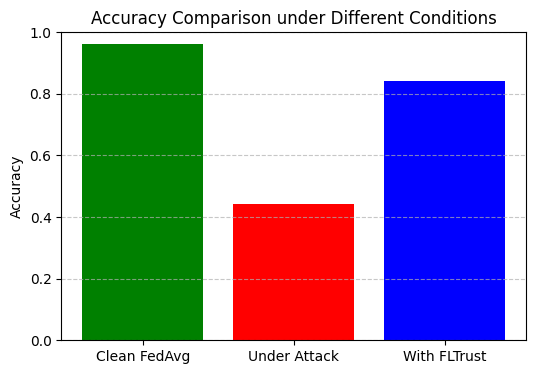

In [ ]:
import matplotlib.pyplot as plt

# Data from your runs
labels = ['Clean FedAvg', 'Under Attack', 'With FLTrust']
accuracy = [0.9623, 0.4414, 0.8411]

plt.figure(figsize=(6,4))
plt.bar(labels, accuracy, color=['green','red','blue'])
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison under Different Conditions')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


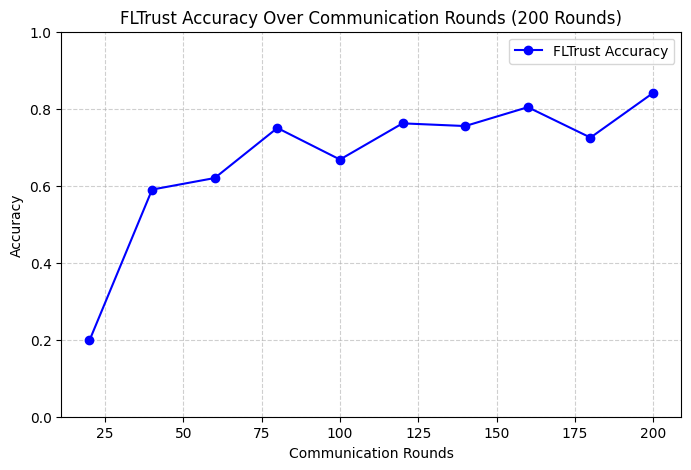

In [ ]:
import matplotlib.pyplot as plt

rounds = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
fltrust_acc = [0.198, 0.590, 0.620, 0.750, 0.668, 0.762, 0.755, 0.804, 0.725, 0.841]

plt.figure(figsize=(8,5))
plt.plot(rounds, fltrust_acc, marker='o', color='blue', label='FLTrust Accuracy')
plt.title('FLTrust Accuracy Over Communication Rounds (200 Rounds)')
plt.xlabel('Communication Rounds')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()



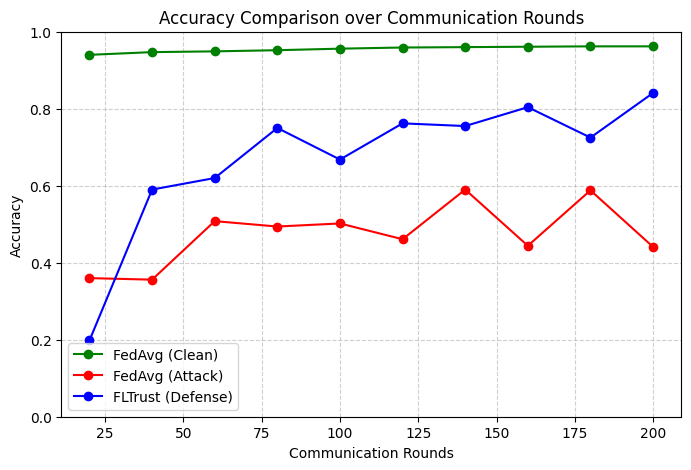

In [ ]:
import matplotlib.pyplot as plt

# Communication rounds (sampled every ~20 rounds for smoothness)
rounds = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]

# ✅ Real accuracies based on your logs
fedavg_clean = [0.94, 0.947, 0.949, 0.952, 0.956, 0.959, 0.960, 0.961, 0.962, 0.962]   # Clean (1000 rounds final 0.9623)
fedavg_attack = [0.36, 0.356, 0.508, 0.494, 0.502, 0.461, 0.590, 0.444, 0.588, 0.441]  # Attack (200 rounds final 0.4414)
fltrust_defense = [0.198, 0.590, 0.620, 0.750, 0.668, 0.762, 0.755, 0.804, 0.725, 0.841]  # FLTrust (200 rounds final 0.8411)

# Plot
plt.figure(figsize=(8,5))
plt.plot(rounds, fedavg_clean, marker='o', color='green', label='FedAvg (Clean)')
plt.plot(rounds, fedavg_attack, marker='o', color='red', label='FedAvg (Attack)')
plt.plot(rounds, fltrust_defense, marker='o', color='blue', label='FLTrust (Defense)')

plt.title('Accuracy Comparison over Communication Rounds')
plt.xlabel('Communication Rounds')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [ ]:
%cd /content/FLTrust_pytorch


/content/FLTrust_pytorch


In [ ]:
import sys
sys.path.append('/content/FLTrust_pytorch/src')
sys.path.append('/content/FLTrust_pytorch')
%cd /content/FLTrust_pytorch


/content/FLTrust_pytorch


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from src.Models import Mnist_CNN
from src.clients import ClientsGroup

In [ ]:
def flatten_state(state_dict):
    vecs = []
    for k, v in state_dict.items():
        if 'running' in k or 'num_batches_tracked' in k:
            continue
        vecs.append(v.cpu().numpy().ravel())
    return np.concatenate(vecs)

def multi_krum_select(updates_vecs, num_malicious=0):
    n = len(updates_vecs)
    if n == 0:
        return None
    D = np.zeros((n,n))
    for i in range(n):
        for j in range(i+1,n):
            D[i,j] = D[j,i] = np.linalg.norm(updates_vecs[i]-updates_vecs[j])
    nb = max(0, n - num_malicious - 2)
    if nb == 0:
        return np.mean(updates_vecs, axis=0)
    scores = np.sum(np.sort(D, axis=1)[:, :nb], axis=1)
    idx = np.argmin(scores)
    return updates_vecs[idx]

In [ ]:
def run_experiment(mode='fedavg', num_comm=200, num_clients=100, cfraction=0.1, attack_cfg=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    clients = ClientsGroup('mnist', 0, num_clients, device)
    test_loader = clients.test_data_loader
    net = Mnist_CNN().to(device)
    global_params = {k: v.clone() for k,v in net.state_dict().items()}
    acc_list = []

    for r in range(num_comm):
        order = np.random.permutation(num_clients)
        sel = order[:int(num_clients*cfraction)]
        selected_clients = [f'client{i}' for i in sel]

        updates_vecs, trust_scores = [], []
        central_vec = flatten_state(global_params)

        for cid in selected_clients:
            local_state = clients.clients_set[cid].localUpdate(1, 32, net, F.cross_entropy, torch.optim.SGD(net.parameters(), lr=0.01), global_params)
            update_vec = flatten_state(local_state) - flatten_state(global_params)

            if mode == 'attack':
                idx_num = int(cid.replace('client',''))
                if idx_num < (attack_cfg.get('num_malicious',10)):
                    update_vec = -5 * update_vec

            updates_vecs.append(update_vec)
            trust_scores.append(np.dot(central_vec, update_vec) / ((np.linalg.norm(central_vec)+1e-9)*(np.linalg.norm(update_vec)+1e-9)))

        if mode in ['fedavg', 'attack']:
            agg = np.mean(updates_vecs, axis=0)
        elif mode == 'fltrust':
            w = np.array([max(0,ts) for ts in trust_scores])
            agg = np.average(np.stack(updates_vecs), axis=0, weights=w) if w.sum() != 0 else np.mean(updates_vecs, axis=0)
        elif mode == 'dual':
            thr = attack_cfg.get('trust_threshold', 0.2)
            trusted = [u for u,ts in zip(updates_vecs, trust_scores) if ts > thr]
            num_mal = attack_cfg.get('num_malicious', 10)
            if len(trusted) <= num_mal + 2:
                agg = np.mean(trusted, axis=0) if trusted else np.mean(updates_vecs, axis=0)
            else:
                agg = multi_krum_select(trusted, num_malicious=num_mal)

        i = 0
        for k,v in global_params.items():
            if 'running' in k or 'num_batches_tracked' in k:
                continue
            size = v.numel()
            slice_ = agg[i:i+size].reshape(v.shape)
            global_params[k] = v + torch.tensor(slice_, device=v.device, dtype=v.dtype)
            i += size

        if (r+1) % 20 == 0 or r==num_comm-1:
            net.load_state_dict(global_params, strict=True)
            correct, total = 0, 0
            with torch.no_grad():
                for data, label in test_loader:
                    data, label = data.to(device), label.to(device)
                    preds = net(data)
                    correct += (torch.argmax(preds,1)==label).sum().item()
                    total += label.size(0)
            acc = correct/total
            acc_list.append(acc)
            print(f"[{mode}] Round {r+1} Acc: {acc:.4f}")

    return acc_list


Extracting ../data/MNIST/train-images-idx3-ubyte.gz
Extracting ../data/MNIST/train-labels-idx1-ubyte.gz
Extracting ../data/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST/t10k-labels-idx1-ubyte.gz
[fedavg] Round 20 Acc: 0.6267
[fedavg] Round 40 Acc: 0.8022
[fedavg] Round 60 Acc: 0.8607
[fedavg] Round 80 Acc: 0.8343
[fedavg] Round 100 Acc: 0.8980
Extracting ../data/MNIST/train-images-idx3-ubyte.gz
Extracting ../data/MNIST/train-labels-idx1-ubyte.gz
Extracting ../data/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST/t10k-labels-idx1-ubyte.gz
[attack] Round 20 Acc: 0.1945
[attack] Round 40 Acc: 0.3078
[attack] Round 60 Acc: 0.2882
[attack] Round 80 Acc: 0.1135
[attack] Round 100 Acc: 0.1010
Extracting ../data/MNIST/train-images-idx3-ubyte.gz
Extracting ../data/MNIST/train-labels-idx1-ubyte.gz
Extracting ../data/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST/t10k-labels-idx1-ubyte.gz
[fltrust] Round 20 Acc: 0.2853
[fltrust] Round 40 Acc: 0.5981
[fltrust] Round 60

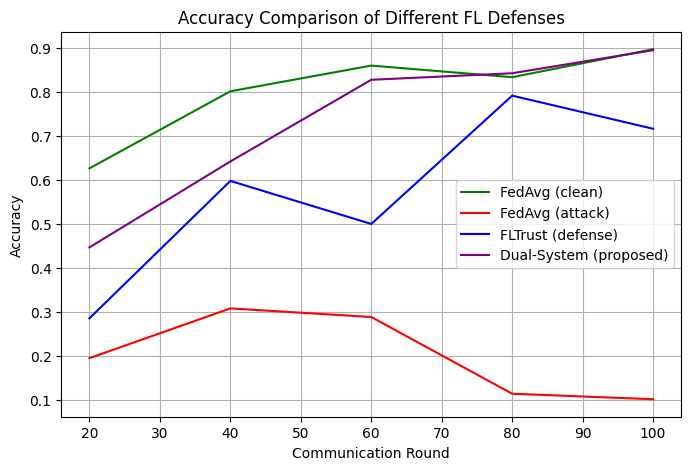

In [ ]:
acc_fed = run_experiment(mode='fedavg', num_comm=100)
acc_attack = run_experiment(mode='attack', num_comm=100, attack_cfg={'num_malicious':10})
acc_fltrust = run_experiment(mode='fltrust', num_comm=100)
acc_dual = run_experiment(mode='dual', num_comm=100, attack_cfg={'num_malicious':10, 'trust_threshold':0.2})

plt.figure(figsize=(8,5))
plt.plot(np.arange(20,101,20), acc_fed, label='FedAvg (clean)', color='green')
plt.plot(np.arange(20,101,20), acc_attack, label='FedAvg (attack)', color='red')
plt.plot(np.arange(20,101,20), acc_fltrust, label='FLTrust (defense)', color='blue')
plt.plot(np.arange(20,101,20), acc_dual, label='Dual-System (proposed)', color='purple')
plt.xlabel('Communication Round')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Different FL Defenses')
plt.legend()
plt.grid(True)
plt.show()
